# S-matrix modeling of acoustic scattering
This notebook is intended to demonstrate the usefulness of simulations and acoustic modeling with the S-matrix formulation. 
The compact S-matrix offers a highly flexible alternative to full-fledged FDTD simulations along with several advantages over them. 

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as npft
from logzero import logger

from scipy.special import hermite

import functools as ftls

import Simulator 
import Pulse as pulse
import smatrix as smat

%matplotlib widget

# User edit

In [21]:
Z = 1.23
for omega in np.arange( 10 )*np.pi*0.39:
    s1 = smat.SMatrix( omega=omega, length=0.25, speed=1.75, Z=np.array( [ 7.45, Z, Z ] ) )
    s2 = smat.SMatrix( omega=omega, length=0.125, speed=1.75, Z=np.array( [ Z, Z, Z ] ) )
    s3 = smat.SMatrix( omega=omega, length=0.5, speed=1.75, Z=np.array( [ Z, Z, 2. ] ) )
    sM=s1*s2*s3
    sN = smat.SMatrix( omega=omega, length=0.875, speed=1.75, Z=np.array( [ 7.45, Z, 2. ] ) )

    print( np.linalg.norm( sM.S - sN.S )/np.abs( np.linalg.eig( sN.S )[0].max() ) )

0.0
3.7263863056628955e-16
2.8074665264976474e-16
3.9460288392725677e-16
4.712321323804736e-16
3.6515002048796167e-16
1.1880715703363181e-15
4.990217849044965e-16
5.368121346699795e-16
6.938893903907225e-16


In [25]:
smat.SMatrix( omega=np.pi, length=1., speed=1.75, Z=np.array( [ 1., 1., 1. ] ) ).S

array([[-0.22252093+0.97492791j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.22252093+0.97492791j]])

In [16]:
np.conj( sN.S.T ) @ sN.S

array([[2.81734071+0.j        , 0.66449102+0.03574227j],
       [0.66449102-0.03574227j, 0.5121233 +0.j        ]])

In [19]:
sN.S, np.conj( sM.S.T ) @ sM.S

(array([[-1.57501317-0.05990191j, -0.57470846-0.05287881j],
        [ 0.57706468-0.00907384j, -0.42282233-0.01608105j]]),
 array([[2.81734071+0.j        , 0.66449102+0.03574227j],
        [0.66449102-0.03574227j, 0.5121233 +0.j        ]]))

In [26]:
num_grid_points = 8000
stack_thickness = 0.025
num_steps = 100000

# pulse details
HG = 15
pulse_location = -0.35
pulse_width = 0.04

def Square( chi ):
    return ( np.abs( chi ) <= 0.5 ).astype( float )


# Material-free simulation
This is done in order to get the incident wave. 

In [28]:
stack_materials = [ [ 1, 1 ] ]
stack_layers = [ 'air' ]
interface_locations = list( np.linspace( -stack_thickness/2, stack_thickness/2, len( stack_layers )-1 ) )
interface_locations.insert( 0, -0.5 )
interface_locations.append( 0.5 )
stack = []
for l, m, left, right in zip( stack_layers, stack_materials, interface_locations[:-1], interface_locations[1:] ):
    stack.append( [ l, m[0], m[1], left, right ] )

# defining initial waveform with constant-phase spectrum
x = np.linspace( -0.5, 0.5, num_grid_points )
chi = ( x - pulse_location ) / pulse_width

# initial = Square( chi )
# initial = np.exp( -0.5 * chi**2 ) * hermite(HG)( chi )
initial = pulse.MysteryPulse( x, pulse_location, pulse_width, order=HG )
# initial = np.roll( initial, np.argmin( np.abs( x-pulse_location ) )-x.size//2 )

initial /= np.abs( initial ).max() 
initial -= initial.mean()

sim = Simulator.Simulator( num_grid_points=num_grid_points, stack=stack )
sim.AddWaveform( initial )
sim.SetUpMonitors( [ -stack_thickness/2, stack_thickness/2 ], visualization=True )
sim.Run( visualize=False, n_iters=num_steps ) #, filename='demo.mp4' )


[I 250901 22:33:44 Simulator:39] δx = 0.000125 (n.u.). 
[I 250901 22:33:44 Simulator:40] δt = 0.000063 (n.u.). 
[I 250901 22:33:44 Simulator:41] Default simulation time = 1.200025 (= 19198 steps)
[W 250901 22:33:44 Simulator:85] Initializing new wave form. 
[I 250901 22:33:44 Simulator:89] Adding wave packet. 
[I 250901 22:33:44 Simulator:64] Monitors set up at grid points [np.float64(-0.012439054881860201), np.float64(0.012564070508813585)]


Running simulation:   0%|          | 0/100000 [00:00<?, ?it/s]

# Extracting incident wave

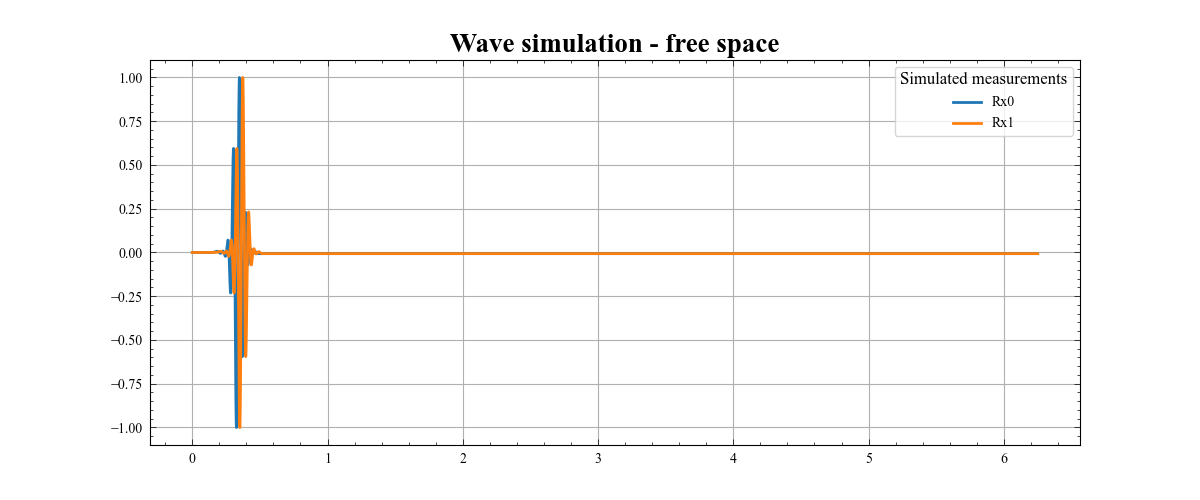

In [29]:
waves = [ val for _, val in sim.monitors.items() ] 
# waves[0] = np.pad( initial, ( ( 0, len( waves[0] ) - len( initial ) ) ) )
t = sim.dt * np.arange( len( waves[0] ) )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    for n in range( 2 ):
        plt.plot( t, waves[n], label=f'Rx{n}', linewidth=2 )
    plt.grid()
    plt.legend( title='Simulated measurements' )
    plt.title( 'Wave simulation - free space' )
    plt.show()

incident_wave = np.array( waves[0] )

# Stack simulation

[I 250901 22:33:51 Simulator:39] δx = 0.000125 (n.u.). 
[I 250901 22:33:51 Simulator:40] δt = 0.000063 (n.u.). 
[I 250901 22:33:51 Simulator:41] Default simulation time = 1.200025 (= 19198 steps)
[W 250901 22:33:51 Simulator:85] Initializing new wave form. 
[I 250901 22:33:51 Simulator:89] Adding wave packet. 
[I 250901 22:33:51 Simulator:64] Monitors set up at grid points [np.float64(-0.012439054881860201), np.float64(0.012564070508813585)]


Running simulation:   0%|          | 0/100000 [00:00<?, ?it/s]

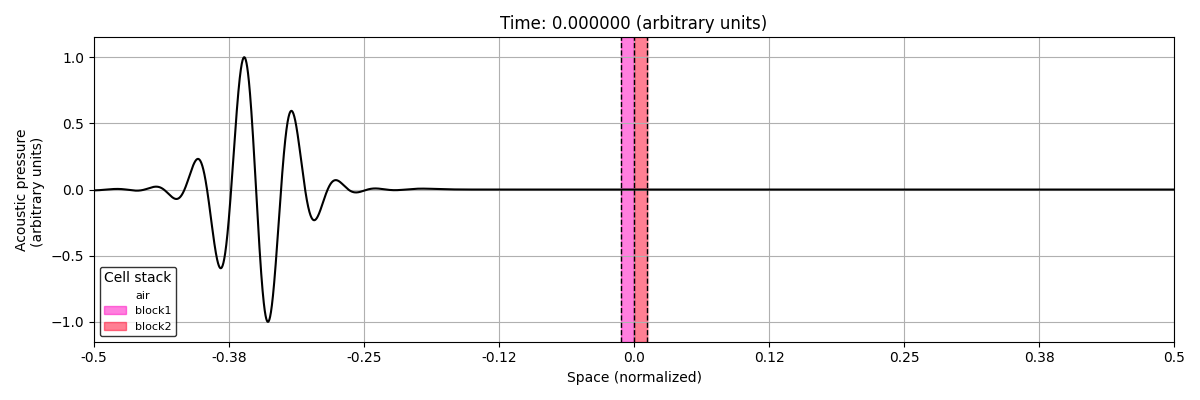

In [ ]:
# one-layer stack
stack_materials = [ [ 1, 1 ], [ 8., 1. ],  [ 8., 1. ], [ 1, 1 ] ]
stack_layers = [ 'air', 'block1', 'block2', 'air' ]

# # two-layer stack
# stack_materials = [ [ 1, 1 ], [ 2., 0.75 ], [ 3., 2. ], [ 1, 1 ] ]
# stack_layers = [ 'air', 'block1', 'block2', 'air' ]


interface_locations = list( np.linspace( -stack_thickness/2, stack_thickness/2, len( stack_layers )-1 ) )
interface_locations.insert( 0, -0.5 )
interface_locations.append( 0.5 )
stack = []
for l, m, left, right in zip( stack_layers, stack_materials, interface_locations[:-1], interface_locations[1:] ):
    stack.append( [ l, m[0], m[1], left, right ] )

# # defining initial waveform
# initial = -pulse.HermiteGauss( np.linspace( -0.5, 0.5, num_grid_points ), location=-0.3, spread=0.025, order=HG )
# initial /= np.abs( initial ).max() 

sim = Simulator.Simulator( num_grid_points=num_grid_points, stack=stack )
sim.AddWaveform( initial )
plt.figure(); sim.SetUpPlot( figsize=( 12, 4 ) )
sim.SetUpMonitors( [ -stack_thickness/2, stack_thickness/2 ], visualization=True )
sim.Run( visualize=False, n_iters=num_steps ) #, filename='demo.mp4' )


# Extracting simulated waveforms

[I 250901 22:33:57 598243920:9] Incident energy	= 3.173e-02
[I 250901 22:33:57 598243920:9] Reflected energy	= 2.426e-02
[I 250901 22:33:57 598243920:9] Transmitted energy	= 7.471e-03
[I 250901 22:33:57 598243920:19] Energy conservation error: 0.0169794%


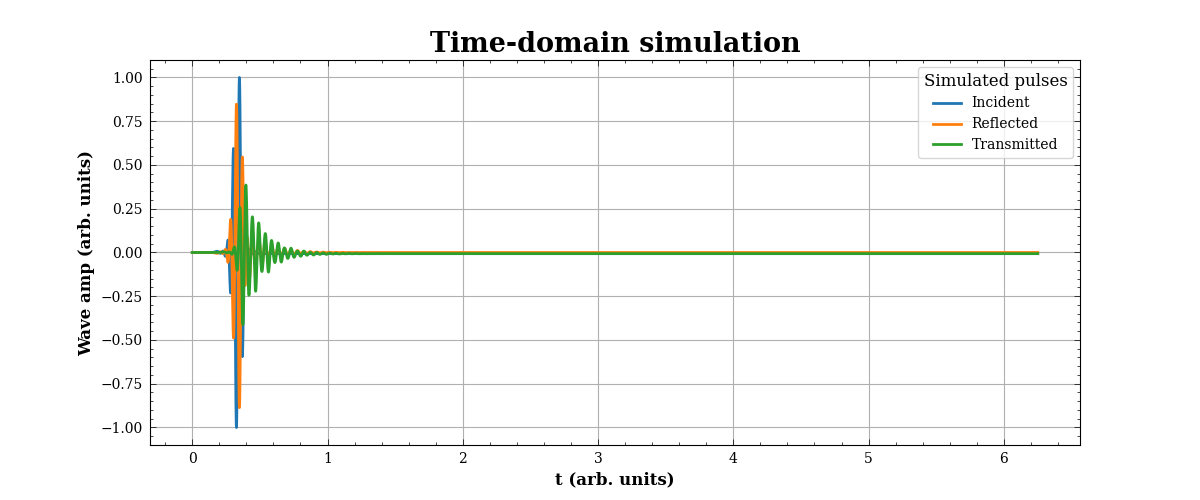

In [31]:
waves_measured = [ np.array( val ) for _, val in sim.monitors.items() ] 
wave_reflected = [ a-b for a, b in zip( waves_measured[0], incident_wave ) ]
energy = []
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ incident_wave, wave_reflected, waves_measured[1] ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        E = sim.dt*( np.abs( wav )**2 ).sum()
        energy.append( E )
        logger.info( f'{lbl} energy\t= {E:.3e}' )
        plt.plot( t, wav, label=lbl, linewidth=2 )
    plt.grid()
    plt.legend( title='Simulated pulses' )
    plt.title( 'Time-domain simulation' )
    plt.xlabel( 't (arb. units)' )
    plt.ylabel( 'Wave amp (arb. units)' )

Ert = energy[1]+energy[2]
error = np.abs( Ert-energy[0] )/energy[0]
logger.info( f'Energy conservation error: {error*100.:.7f}%' )



In [32]:
speed, density = zip( *stack_materials )
Z = np.array( [ a*b for a, b in zip( speed, density ) ] ) # acoustic impedances
R = ( ( Z[0]-Z[1] )/( Z[1]+Z[0] ) )**2 # energy reflection coefficient


# Fourier representation of waves
This is the ground truth against which the output of the S-matrix will be computed , for each frequency.

In [33]:
freqs = npft.fftfreq( len( incident_wave ), d=sim.dt )
freqs = freqs[ freqs >= 0. ] 
df = ( freqs[1:] - freqs[:-1] ).mean()
freqs = np.array( list( freqs ) + [ freqs[-1] + df ] )

fwav_inc = npft.rfft( incident_wave, norm='ortho' )
fwav_ref = npft.rfft( wave_reflected, norm='ortho' )
fwav_trn = npft.rfft( waves_measured[1], norm='ortho' )

logger.info( f'Fourier components\t= {freqs.size}' )
logger.info( f'Frequency step\t= {df:.3e}' )

[I 250901 22:34:02 1177834418:10] Fourier components	= 50001
[I 250901 22:34:02 1177834418:11] Frequency step	= 1.600e-01


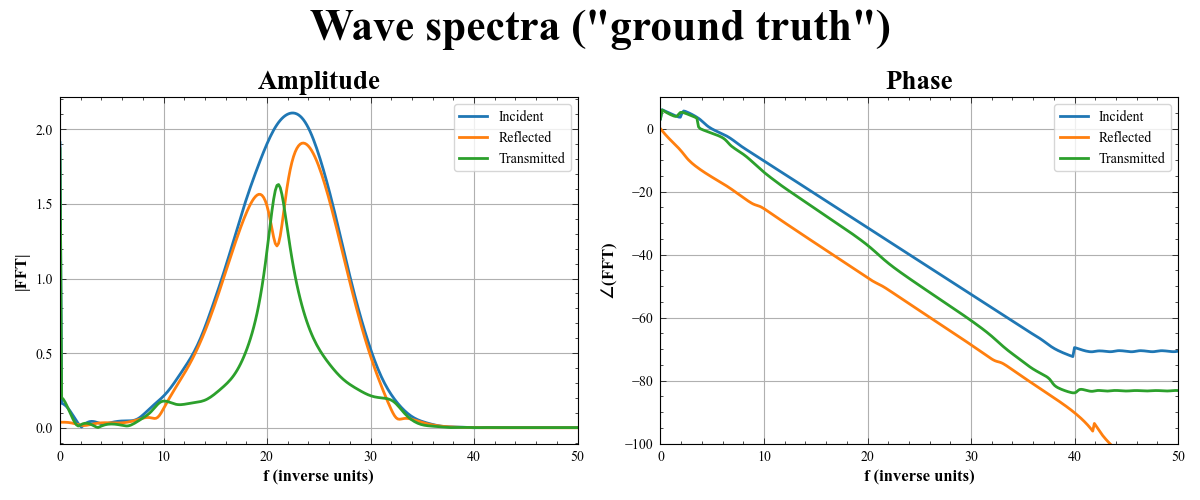

[I 250901 22:34:03 1253747775:35] Incident spectrum total energy = 6.4631267e+00
[I 250901 22:34:03 1253747775:35] Reflected spectrum total energy = 4.9404210e+00
[I 250901 22:34:03 1253747775:35] Transmitted spectrum total energy = 1.5216084e+00
[I 250901 22:34:03 1253747775:38] Energy conservation error = 1.6979356e-02%
[I 250901 22:34:03 1253747775:39] Energy conservation error (in multiples of machine zero) = 764682220836.575561523437500
[I 250901 22:34:03 1253747775:40] Theoretical reflected energy (first bounce) = 3.9097927e+00


In [34]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )
    
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[0].plot( freqs, np.abs( wav ), label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( 'f (inverse units)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 2/pulse_width ] )
    
    # ax.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[1].plot( freqs, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    # ax[1].set_xlim( [ 0., 3/pulse_width ] )
    ax[1].set_ylim( [ -100., 10. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( 'f (inverse units)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra (\"ground truth\")' )
    plt.tight_layout()
    plt.show()


df = ( freqs[1:] - freqs[:-1] ).mean()
Ef = []
for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2.*np.pi )
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}%' )
logger.info( f'Energy conservation error (in multiples of machine zero) = {dE_E/np.finfo( float ).eps:.15f}' )
logger.info( f'Theoretical reflected energy (first bounce) = {Ef[0]*R:.7e}' )

# Harmonic analysis
Uncomment the next cell if the input pulse is a square pulse. 
Instead of relying on the square pulse spectrum obtained from the simulation (subject to discretization errors), it's better to analytically form the spectrum that will go into the S-matrix. 

In [35]:
# fwav_inc = np.sinc( freqs * pulse_width / speed[0] ).astype( complex )
# delay = ( -stack_thickness/2. - ( pulse_location + pulse_width/2. ) ) / speed[0]
# phase_ramp = np.exp( -2.j * np.pi * freqs * delay )
# fwav_inc *= phase_ramp

In [43]:

length

[np.float64(0.0125), np.float64(0.0125)]

In [38]:
input = np.concatenate( [ arr[np.newaxis,:] for arr in [ fwav_inc, np.zeros( fwav_inc.shape ) ] ], axis=0 )

# build propagator
if len( stack_layers ) == 3:
    propagator = ftls.partial( smat.SMatrix, length=stack_thickness, speed=float( speed[1] ), Z=Z, time_scaler=sim.dt )
else: 
    length = [b-a for b, a in zip( interface_locations[2:-1], interface_locations[1:-2] ) ]
    propagators = [ 
        ftls.partial( smat.SMatrix, length=l, speed=s, Z=Z[n:n+3], time_scaler=sim.dt )
        for n, ( l, s ) in enumerate( zip( length, speed[1:-1] ) )
    ]

start_time = time.time()
all_outputs = []
for n, omega_test in enumerate( 2.*np.pi*freqs ):
    
    if len( stack_layers ) == 3: 
        S = propagator( omega=omega_test ).S
        output = S @ input[:,n][:,np.newaxis]
    else:
        S = ftls.reduce( lambda x, y: x*y, [ prop( omega=omega_test ) for prop in propagators ] )
        output = S.S @ input[:,n][:,np.newaxis]

    all_outputs.append( output )
elapsed_time = time.time() - start_time
logger.info( f'S-matrix simulation took {elapsed_time:.6f} seconds to reconstruct {freqs.size} Fourier components. ' )


all_outputs = np.concatenate( all_outputs, axis=1 )

[I 250901 22:34:37 3371297686:26] S-matrix simulation took 1.475296 seconds to reconstruct 50001 Fourier components. 


[I 250901 22:34:40 3999633406:31] Incident spectrum total energy = 6.4631267e+00
[I 250901 22:34:40 3999633406:31] Reflected spectrum total energy = 6.2061280e+00
[I 250901 22:34:40 3999633406:31] Transmitted spectrum total energy = 1.4685641e+00
[I 250901 22:34:40 3999633406:34] Energy conservation error = 1.8745809e+01
[I 250901 22:34:40 3999633406:35] Energy conservation error (in multiples of machine zero) = 844236195229885.625000000000000
[I 250901 22:34:40 3999633406:36] Theoretical reflected energy (first bounce) = 3.9097927e+00


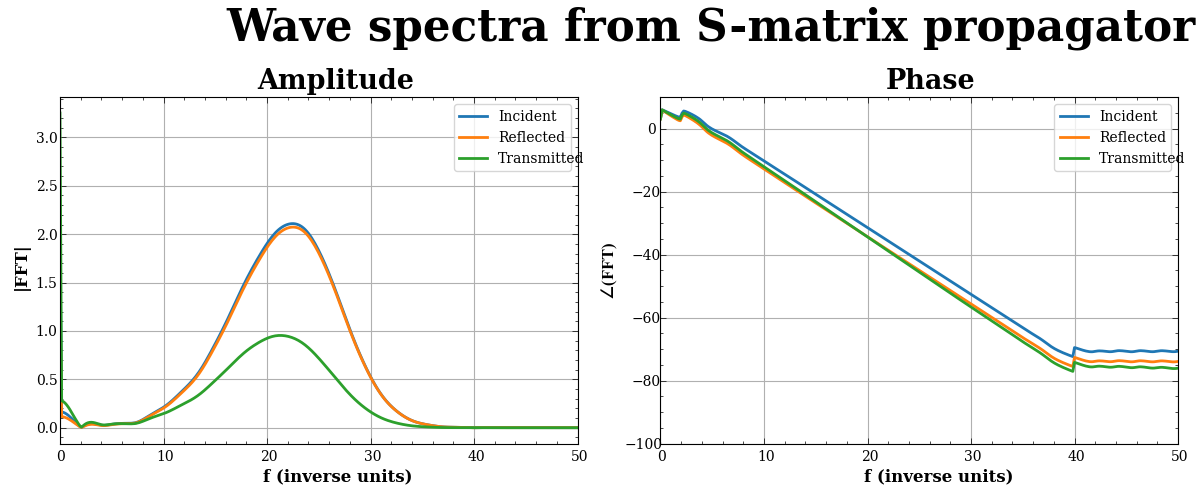

In [39]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )
    
    for wav, lbl in zip( [ fwav_inc, all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[0].plot( freqs, np.abs( wav )[:freqs.size], label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( 'f (inverse units)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 2/pulse_width ] )
    
    for wav, lbl in zip( [ fwav_inc, all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[1].plot( freqs, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    ax[1].set_ylim( [ -100., 10. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( 'f (inverse units)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra from S-matrix propagator' )
    plt.tight_layout()
    
df = ( freqs[1:] - freqs[:-1] ).mean()
Ef = []
for wav, lbl in zip( [ fwav_inc[:-1], all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2. * np.pi )
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}')
logger.info( f'Energy conservation error (in multiples of machine zero) = {dE_E/np.finfo( float ).eps:.15f}' )
logger.info( f'Theoretical reflected energy (first bounce) = {Ef[0]*R:.7e}')

plt.show()

# Simulated waveforms from S-matrix
Compare these to the simulated waveforms plotted earlier. 

In [40]:
back = npft.irfft( fwav_inc, norm='ortho' )
back_r = npft.irfft( all_outputs[1], norm='ortho' ) # negative sign because it's moving in theopposite direction in space
back_t = npft.irfft( all_outputs[0], norm='ortho' )

[I 250901 22:34:44 2598241353:6] Incident energy	= 3.173e-02
[I 250901 22:34:44 2598241353:6] Reflected energy	= 3.047e-02
[I 250901 22:34:44 2598241353:6] Transmitted energy	= 7.211e-03
[I 250901 22:34:44 2598241353:17] Energy conservation error: 0.0169794%


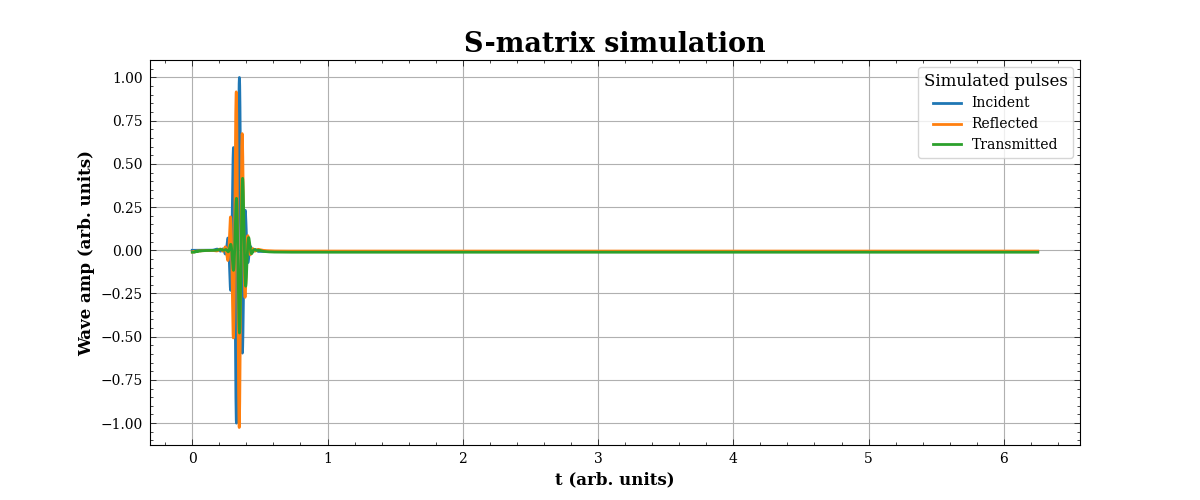

In [41]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        E = sim.dt*( np.abs( wav )**2 ).sum()
        energy.append( E )
        logger.info( f'{lbl} energy\t= {E:.3e}' )
        plt.plot( t[:wav.size], wav, label=lbl, linewidth=2 )
    plt.grid()
    plt.legend( title='Simulated pulses' )
    plt.title( 'S-matrix simulation' )
    plt.xlabel( 't (arb. units)' )
    plt.ylabel( 'Wave amp (arb. units)' )
    

Ert = energy[1]+energy[2]
error = np.abs( Ert-energy[0] )/energy[0]
logger.info( f'Energy conservation error: {error*100.:.7f}%' )

plt.show()



# Comparison plots

[I 250901 22:34:48 3111839475:10] Incident error: 2.663e-17
[I 250901 22:34:48 3111839475:10] Reflected error: 8.141e-03
[I 250901 22:34:48 3111839475:10] Transmitted error: 1.445e-02


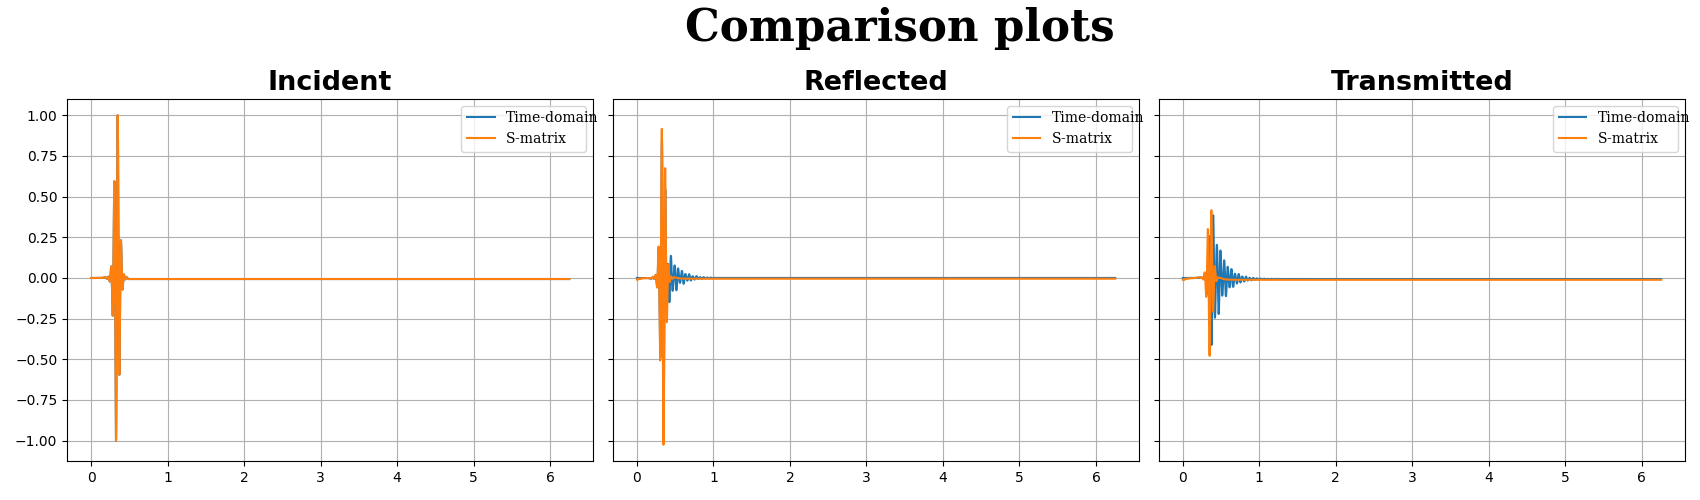

In [42]:
ax = plt.figure( figsize=( 17, 5 ) ).subplots( 1, 3, sharex=True, sharey=True )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    for n, ( wav1, wav2, lbl ) in enumerate( zip( [ incident_wave, wave_reflected, waves_measured[1] ], [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[n].plot( t, wav1, label='Time-domain' )
        ax[n].plot( t, wav2, label='S-matrix' )
        ax[n].grid()
        ax[n].legend()
        ax[n].set_title( lbl )
        logger.info( f'{lbl} error: {np.abs( wav1-wav2 ).sum()/np.array( wav1 ).size:.3e}' )
    plt.suptitle( 'Comparison plots' )
    plt.tight_layout()
